In [ ]:
import os
import clip
import torch
import numpy as np
from PIL import Image

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32")
image_dir = 'S:\\PolySecLabProjects\\eeg-image-decoding\\data\\all-joined-1\\coco\\images'
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]

def get_embedding(img_path):
    if not os.path.exists(img_path):
        print(f"Missing file: {img_path}")
        return None
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)  # move to same device
    with torch.no_grad():
        return model.encode_image(image).squeeze().cpu().numpy()  # move back to CPU before .numpy()
    
embeddings = np.array([get_embedding(path) for path in image_paths])

In [4]:
embeddings.shape, embeddings

((960, 512),
 array([[-0.585   ,  0.3271  , -0.0572  , ...,  0.205   ,  0.095   ,
          0.3413  ],
        [-0.04578 ,  0.5723  ,  0.04068 , ...,  0.874   , -0.3938  ,
         -0.1092  ],
        [-0.3716  , -0.2222  ,  0.004242, ...,  0.7417  , -0.219   ,
          0.2026  ],
        ...,
        [-0.6     , -0.02597 ,  0.1655  , ...,  0.3137  ,  0.10547 ,
          0.06055 ],
        [ 0.2188  ,  0.2856  , -0.1918  , ...,  0.222   , -0.2878  ,
         -0.2445  ],
        [-0.00415 , -0.0644  , -0.122   , ...,  0.0633  , -0.05856 ,
         -0.006275]], shape=(960, 512), dtype=float16))

In [5]:
from sklearn.cluster import KMeans

n_clusters = 20  # or based on elbow method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(embeddings)

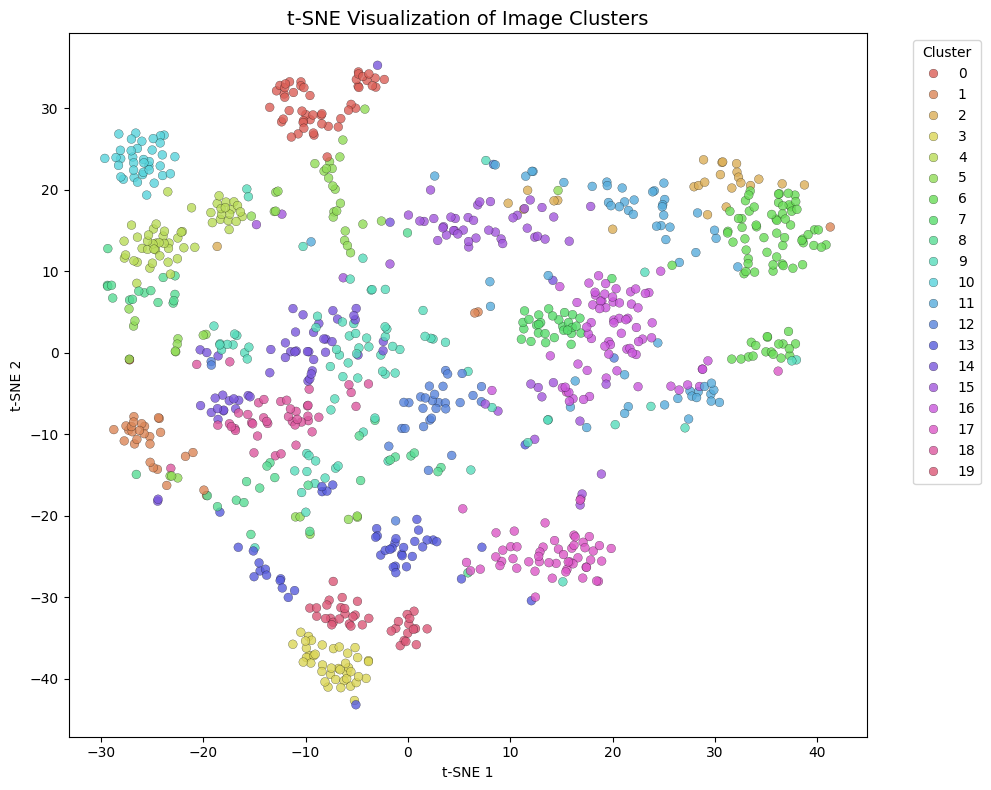

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Assuming you have:
# embeddings: np.array, shape (960, D)
# cluster_ids: np.array or list, shape (960,)

# Step 1: Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding_2d = tsne.fit_transform(embeddings)

# Step 2: Plot using Seaborn
plt.figure(figsize=(10, 8))
num_clusters = len(set(cluster_ids))
palette = sns.color_palette("hls", num_clusters)

sns.scatterplot(
    x=embedding_2d[:, 0],
    y=embedding_2d[:, 1],
    hue=cluster_ids,
    palette=palette,
    s=40, edgecolor='k', linewidth=0.2, alpha=0.8,
)

plt.title("t-SNE Visualization of Image Clusters", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [8]:
from collections import defaultdict
import random

# Group image paths by cluster ID
cluster_to_images = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_to_images[cluster_id].append(image_paths[idx])

# Sample N images from each cluster
def sample_cluster_images(cluster_to_images, n_samples=5):
    sampled = {}
    for cluster_id, paths in cluster_to_images.items():
        sampled[cluster_id] = random.sample(paths, min(n_samples, len(paths)))
    return sampled

# Example: get 5 images per cluster
sampled_images = sample_cluster_images(cluster_to_images, n_samples=5)

# Print example output
for cid, paths in sampled_images.items():
    print(f"Cluster {cid}:")
    for path in paths:
        print(f"  - {path}")

Cluster 10:
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\266.jpg
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\400.jpg
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\790.jpg
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\429.jpg
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\357.jpg
Cluster 6:
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\334.jpg
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\162.jpg
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\123.jpg
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\391.jpg
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\35.jpg
Cluster 3:
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-joined-1\coco\images\731.jpg
  - S:\PolySecLabProjects\eeg-image-decoding\data\all-

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_cluster_samples(sampled_images, images_per_cluster=5, thumb_size=(100, 100)):
    """
    sampled_images: dict {cluster_id: list of image paths}
    images_per_cluster: how many images to show per cluster
    thumb_size: pixel size of each thumbnail
    """
    n_clusters = len(sampled_images)
    fig, axes = plt.subplots(n_clusters, images_per_cluster, figsize=(images_per_cluster * 2, n_clusters * 2))

    if n_clusters == 1:
        axes = [axes]  # force 2D array shape if only 1 cluster

    for row, (cluster_id, paths) in enumerate(sorted(sampled_images.items())):
        for col in range(images_per_cluster):
            ax = axes[row][col] if n_clusters > 1 else axes[col]
            ax.axis('off')
            try:
                img_path = paths[col]
                img = Image.open(img_path).resize(thumb_size)
                ax.imshow(img)
            except IndexError:
                ax.set_facecolor("lightgray")
            except Exception as e:
                ax.set_title("Error")
                ax.set_facecolor("red")
                print(f"Failed to load {img_path}: {e}")
        axes[row][0].set_ylabel(f"Cluster {cluster_id}", fontsize=12)

    plt.tight_layout()
    plt.show()

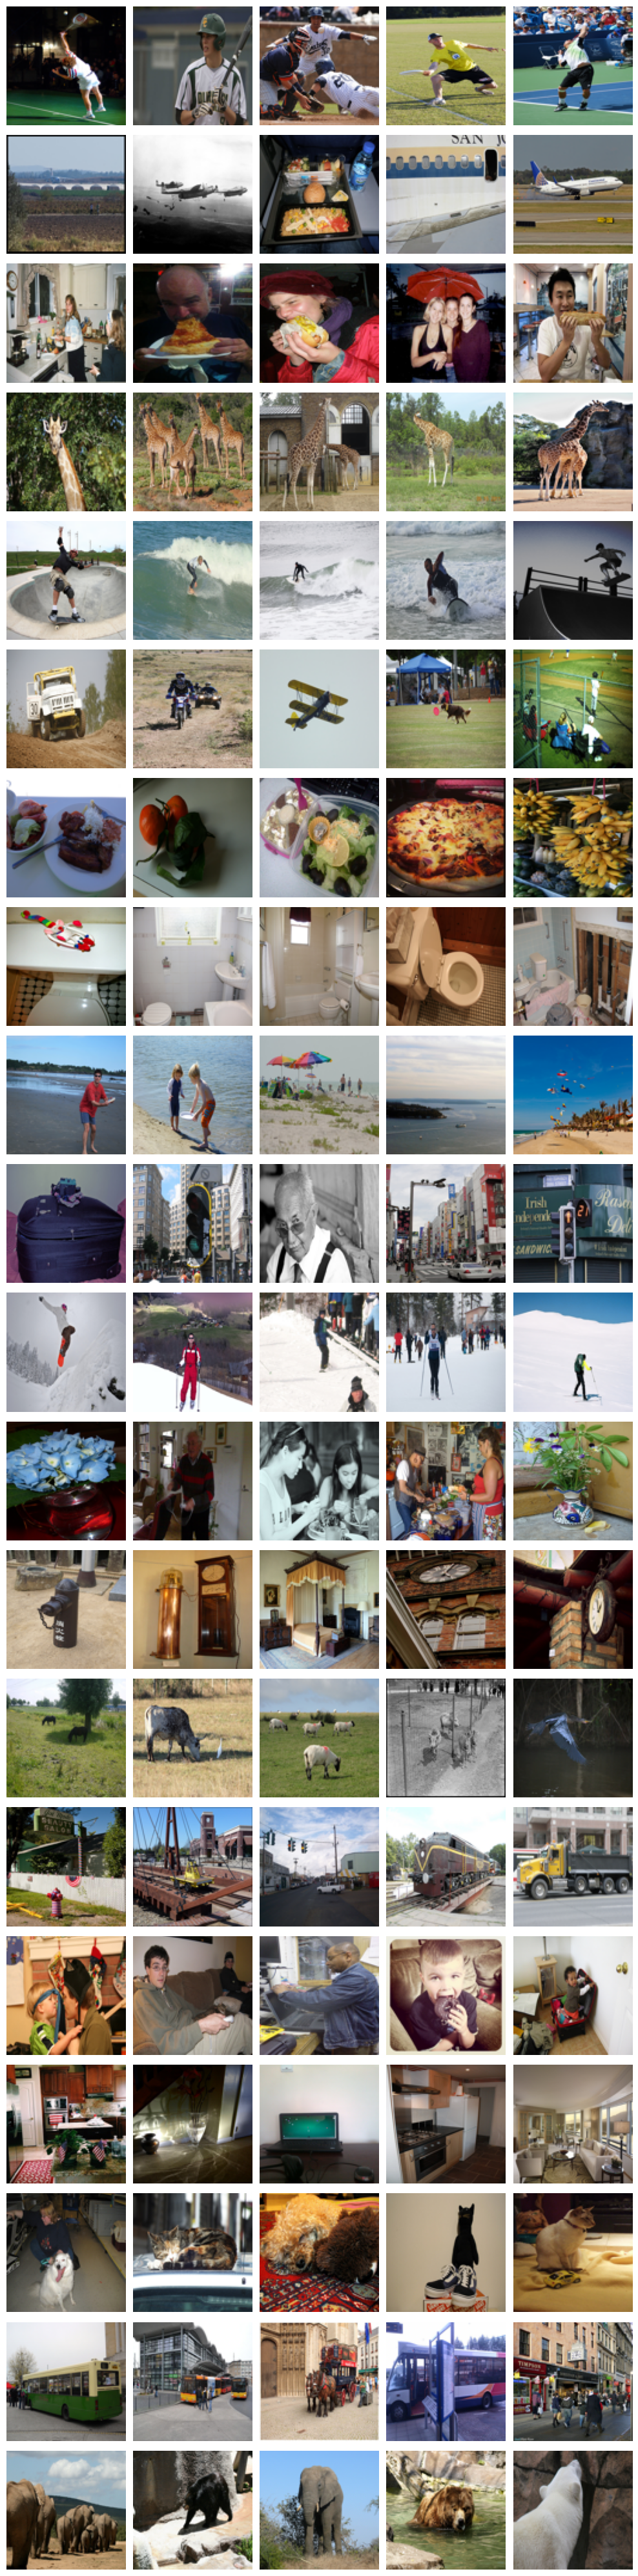

In [10]:
# sampled_images: dict from previous step (e.g., 5 images per cluster)
plot_cluster_samples(sampled_images, images_per_cluster=5)

In [11]:
from collections import defaultdict
import random

def split_by_cluster_proportional(image_paths, cluster_ids, test_size=160, seed=42):
    random.seed(seed)
    total_images = len(image_paths)

    # Step 1: Group image indices by cluster
    cluster_to_indices = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_to_indices[cluster_id].append(idx)

    # Step 2: Compute test samples per cluster (proportional)
    cluster_test_allocations = {}
    for cluster_id, indices in cluster_to_indices.items():
        share = len(indices) / total_images
        cluster_test_allocations[cluster_id] = round(share * test_size)

    # Step 3: Sample test indices
    test_indices = set()
    for cluster_id, n_test in cluster_test_allocations.items():
        cluster_indices = cluster_to_indices[cluster_id]
        test_samples = random.sample(cluster_indices, min(n_test, len(cluster_indices)))
        test_indices.update(test_samples)

    # Step 4: Remaining are train
    all_indices = set(range(total_images))
    train_indices = all_indices - test_indices

    # Step 5: Get final image lists
    train_images = [image_paths[i] for i in sorted(train_indices)]
    test_images = [image_paths[i] for i in sorted(test_indices)]

    return train_images, test_images

In [12]:
train_images, test_images = split_by_cluster_proportional(image_paths, cluster_ids)
print(f"Train: {len(train_images)} images")
print(f"Test: {len(test_images)} images")

Train: 800 images
Test: 160 images


In [16]:
sorted([int(i.split('\\')[-1].replace('.jpg', '')) for i in train_images])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 9,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 28,
 29,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 40,
 42,
 43,
 44,
 45,
 46,
 47,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 67,
 69,
 72,
 73,
 74,
 75,
 76,
 78,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 139,
 140,
 142,
 143,
 145,
 146,
 148,
 149,
 150,
 151,
 152,
 153,
 156,
 157,
 158,
 161,
 164,
 165,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 183,
 184,
 185,
 186,
 187,
 189,
 190,
 192,
 194,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 212,
 213,
 214,
 215,
 216,
 217,
 220,
 221,
 222,
 22

In [17]:
sorted([int(i.split('\\')[-1].replace('.jpg', '')) for i in test_images])

[8,
 10,
 11,
 24,
 26,
 27,
 30,
 39,
 41,
 48,
 50,
 62,
 65,
 66,
 68,
 70,
 71,
 77,
 79,
 83,
 111,
 121,
 138,
 141,
 144,
 147,
 154,
 155,
 159,
 160,
 162,
 163,
 166,
 181,
 182,
 188,
 191,
 193,
 195,
 211,
 218,
 219,
 240,
 248,
 252,
 253,
 258,
 266,
 270,
 276,
 280,
 281,
 285,
 286,
 291,
 297,
 301,
 304,
 311,
 322,
 325,
 341,
 342,
 345,
 348,
 358,
 369,
 370,
 375,
 379,
 381,
 391,
 401,
 404,
 408,
 410,
 414,
 420,
 421,
 422,
 424,
 428,
 429,
 432,
 434,
 453,
 462,
 473,
 476,
 504,
 517,
 518,
 527,
 543,
 544,
 546,
 548,
 555,
 556,
 558,
 568,
 579,
 598,
 603,
 625,
 640,
 656,
 660,
 663,
 668,
 669,
 674,
 678,
 680,
 682,
 684,
 692,
 700,
 701,
 703,
 709,
 710,
 716,
 723,
 746,
 747,
 767,
 769,
 770,
 779,
 783,
 805,
 813,
 822,
 825,
 830,
 833,
 837,
 845,
 848,
 853,
 854,
 860,
 862,
 865,
 868,
 870,
 884,
 887,
 900,
 906,
 908,
 925,
 927,
 932,
 935,
 936,
 937,
 939,
 940]